In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
def import_package(depth: int, is_jupyter: bool):
    if is_jupyter is False:
        current_dir = os.path.dirname(os.path.abspath(__file__))
    else:
        current_dir = os.getcwd()

    parent_dir = current_dir
    while depth > 0:
        depth -= 1
        parent_dir = os.path.dirname(parent_dir)
    print(current_dir)
    print(parent_dir)
    sys.path.insert(0, parent_dir)

import_package(1, True)

C:\Users\Surface Pro\Desktop\instacart
C:\Users\Surface Pro\Desktop


In [4]:
departments= pd.read_csv('departments.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
departments #Mabe we do not use this

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [6]:
order_products__prior #2

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [7]:
order_products__train #2

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [8]:
orders #1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [9]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [10]:
sample_submission

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259
...,...,...
74995,3420740,39276 29259
74996,3420877,39276 29259
74997,3420888,39276 29259
74998,3420989,39276 29259


## Explain

In [11]:
"""
Goal:
The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.
For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order

-Table: orders
    +order_id: id of order (PK)
    +user_id: id of user
    +eval_set: Type of customer (prior, train, test)
        In this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. 
        ->So the last order of the user has been taken out and divided into train and test sets

        ++prior: prior orders dataset  
        ++train: train dataset of the last order
        ++test: test dataset of the last order

    +order_number: number of order
    +order_dow: order in day of week(from 0 -> 6) <But we don't know which values represent which day
    +order_hour_of_day: order in  hour of a day (0->23) 
    +days_since_prior_order: Day that people buy again

-Table: order_products__train: information about train order
    +order_id: id of order
    +product_id: id of product
    +PK: order_id + product_id
    +add_to_cart_order: number of product of that order that people add to cart(buy)
    +reordered: Is that order 

-Table: order_product_prior: information about prior order

-Table: product: product information
    product_id(PK)
    product_name
    aisle_id
    department_id
"""

"\nGoal:\nThe dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.\nFor each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order\n\n-Table: orders\n    +order_id: id of order (PK)\n    +user_id: id of user\n    +eval_set: Type of customer (prior, train, test)\n        In this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. \n        ->So the last order of the user has been taken out and divided into train and test sets\n\n        ++prior: prior orders dataset  \n        ++train: train dataset of the last order\n        ++test: test dataset of the last order\n\n    +order_number: number of order\n    +order_dow: order in day of week(from 0 -> 6) <But we don't know which values represent which day\n    +order_hour_of_day: order in  hour of a day (0->23) \n    +days_since_prior_order: Day tha

## EDA

In [12]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [13]:
for i in range(len(orders.columns)): #Check the percetntage of Nan
    missing_data = orders[orders.columns[i]].isna().sum()
    perc = missing_data / len(orders[orders.columns[i]]) * 100
    print(str(orders.columns[i])+' has missing entries: %d, which is %.2f percent of total' % (missing_data, perc))

order_id has missing entries: 0, which is 0.00 percent of total
user_id has missing entries: 0, which is 0.00 percent of total
eval_set has missing entries: 0, which is 0.00 percent of total
order_number has missing entries: 0, which is 0.00 percent of total
order_dow has missing entries: 0, which is 0.00 percent of total
order_hour_of_day has missing entries: 0, which is 0.00 percent of total
days_since_prior_order has missing entries: 206209, which is 6.03 percent of total


In [14]:
color = sns.color_palette()


D:\Anaconda\Anaconda Source\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


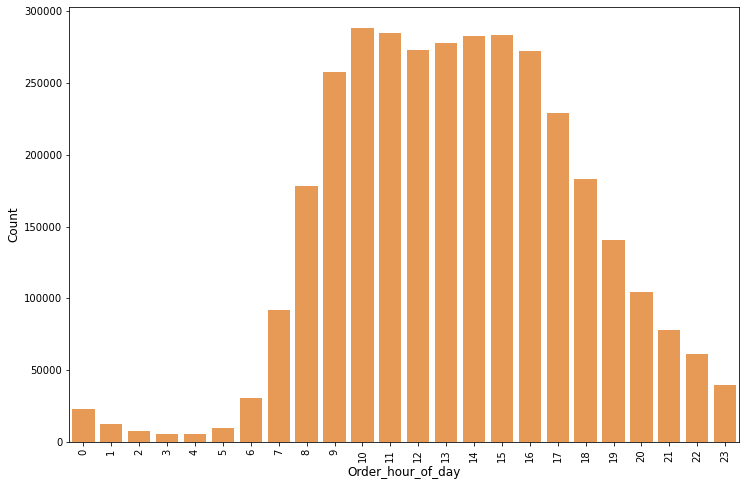

In [15]:
cnt_srs = orders.order_hour_of_day.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Order_hour_of_day', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [16]:
#Most often order from 8 -> 18

D:\Anaconda\Anaconda Source\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


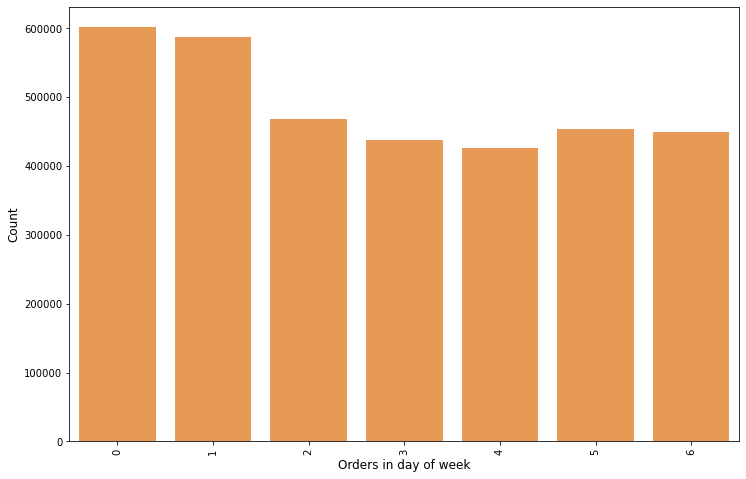

In [17]:
cnt_srs = orders.order_dow.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Orders in day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [18]:
# Day 0 and Day 1 is max

In [19]:
# cnt_srs = orders.value_counts()

# plt.figure(figsize=(25,8))
# sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
# plt.ylabel('Count', fontsize=12)
# plt.xlabel('Number of order', fontsize=12)
# plt.xticks(rotation='vertical')
# plt.show()

In [20]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [21]:
#There always at least 3 prior orders

D:\Anaconda\Anaconda Source\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


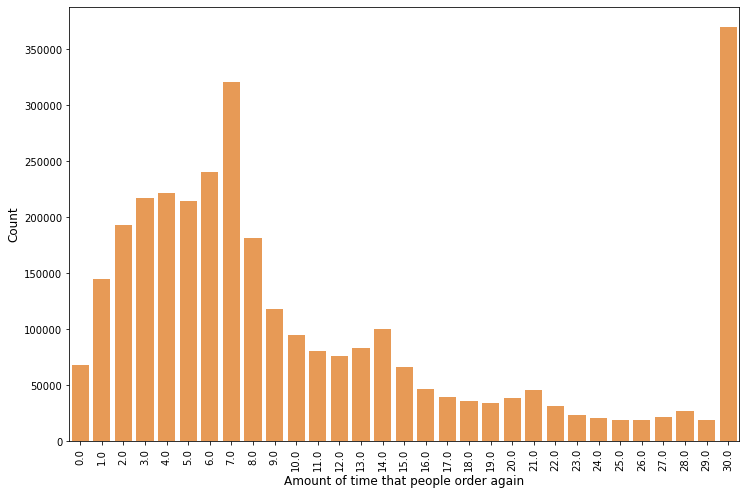

In [22]:
cnt_srs = orders.days_since_prior_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount of time that people order again', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

People tends to buy things after 1 week, small peak at 14, 21, 28 days

### order_products__prior

In [23]:
order_products__prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [24]:
# percentage of re-orders in prior set #
order_products__prior.reordered.sum() / len(order_products__prior)

0.5896974667922161

In [25]:
def encode_units(x): #decode unit
    if x <= 0:
        return 0
    if x >= 1: 
        return 1 

In [26]:

# percentage of no re-orders products
grouped_df = order_products__prior.groupby("order_id")["reordered"].aggregate("sum").reset_index() #groupby order_id by sum
grouped_df.reordered = grouped_df.reordered.map(encode_units) #apply mapping encode_units that reordered product is 1, non reordered product is 0

grouped_df.reordered.value_counts() / len(grouped_df) #calculate percentage of no re-orders products

1    0.879151
0    0.120849
Name: reordered, dtype: float64

D:\Anaconda\Anaconda Source\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


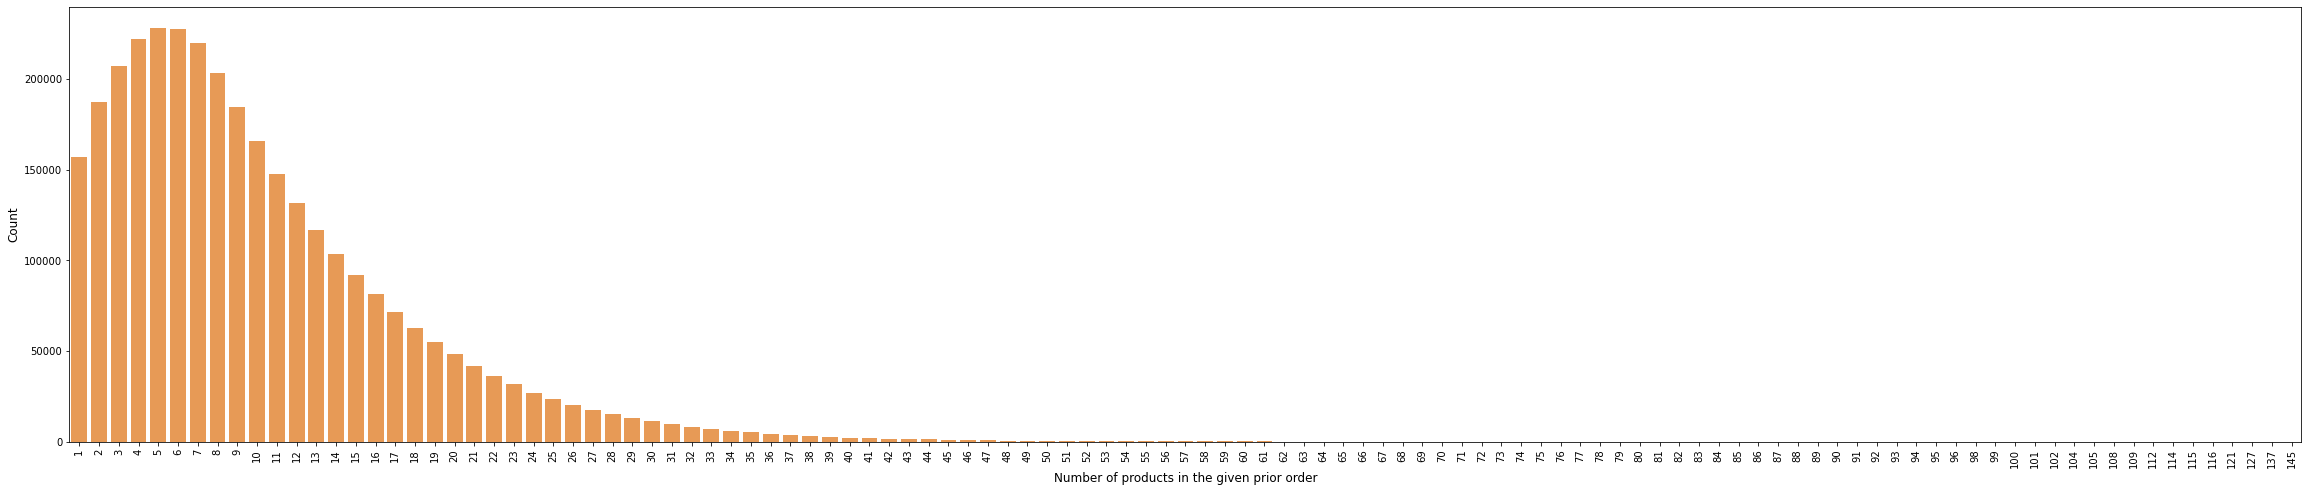

In [27]:
grouped_df = order_products__prior.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index() # groupby order_id by max

cnt_srs = grouped_df.add_to_cart_order.value_counts() #count the appearance of each element

plt.figure(figsize=(40,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of products in the given prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [28]:
order_products__train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [29]:
# percentage of re-orders in prior set #
order_products__train.reordered.sum() / len(order_products__train)

0.5985944127509629

In [30]:

# percentage of no re-orders products
grouped_df = order_products__train.groupby("order_id")["reordered"].aggregate("sum").reset_index() #groupby order_id by sum
grouped_df.reordered = grouped_df.reordered.map(encode_units) #apply mapping encode_units that reordered product is 1, non reordered product is 0

grouped_df.reordered.value_counts() / len(grouped_df) #calculate percentage of no re-orders products

1    0.93444
0    0.06556
Name: reordered, dtype: float64

D:\Anaconda\Anaconda Source\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


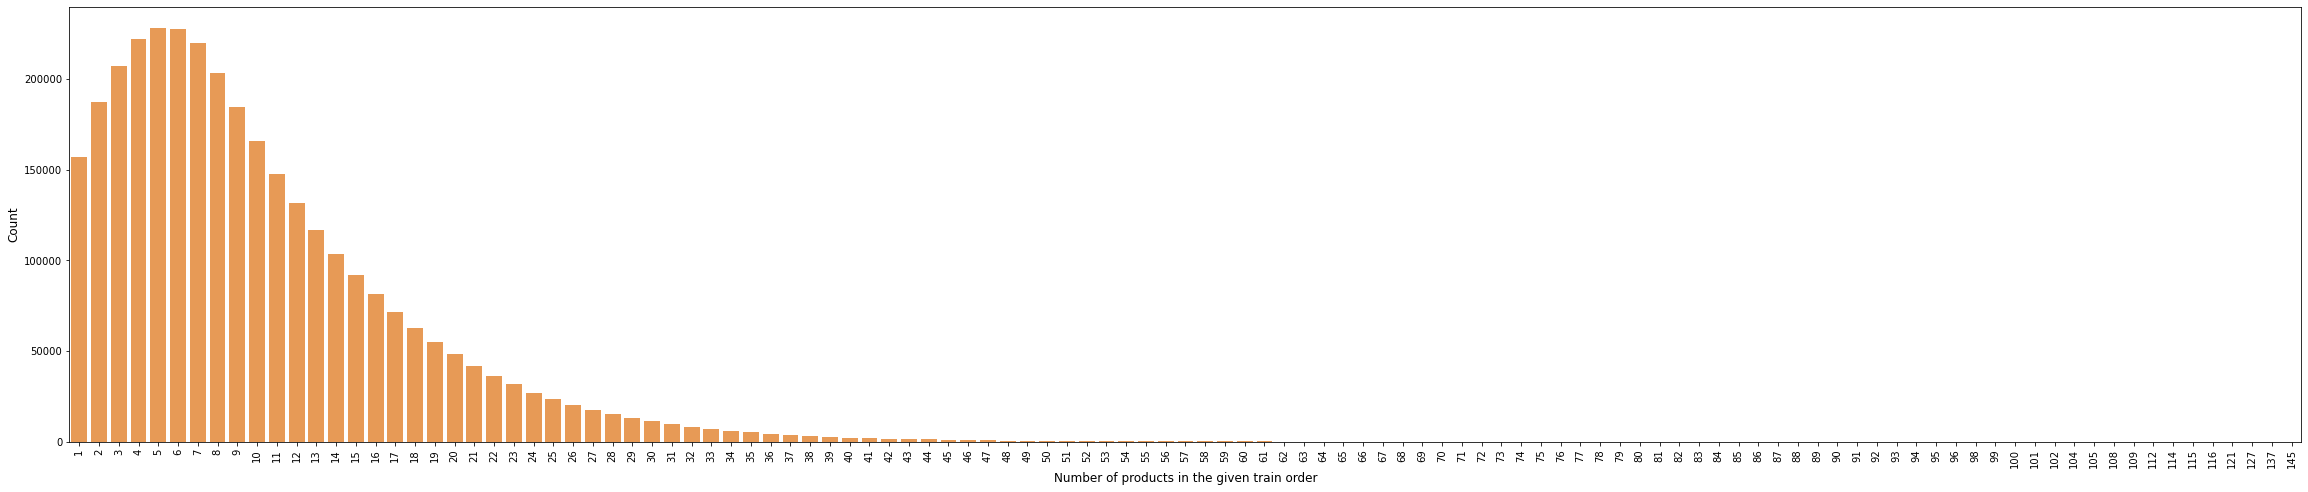

In [31]:
grouped_df = order_products__prior.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()

cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(40,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of products in the given train order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [32]:
order_products__train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [33]:
order_products__prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [34]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [35]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [36]:
order_products__train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


# Apriori get ready

## First approach, finding the item association rules

In [ ]:
#we work on a copy of the order_products__train
order_products__train_copy = order_products__train[:]

In [ ]:
order_products__train_product_id = order_products__train[:]['product_id']
order_products__train_copy = pd.merge(order_products__train_copy, products, on="product_id")

I prefer working with a set that includes the name of the product

In [ ]:
order_products__train_copy.drop(["aisle_id", "department_id"], axis = 1)

In [ ]:
#reorganize the columns
order_products__train_copy = order_products__train_copy[['order_id', 'product_id', 'product_name', 'add_to_cart_order', 'reordered']]
order_products__train_copy

We want to count how many items are in each order since it makes more sense to suggest customers with a lot of items in their carts to buy more, customers with only a handful of items (< 5) are more likely to have some particular items in mind and therefore harder to encourage to buy more

In [ ]:
order_products__train_copy_count = order_products__train_copy.groupby(['order_id']).size().reset_index(name='counts')

this are the order which order more than 5 items, we will now join this will the original order_products__train table

In [ ]:
order_products__train_copy_count = order_products__train_copy_count.loc[order_products__train_copy_count['counts'] >= 5]

In [ ]:
order_products__train_copy_count

We will now merge make the file with the count file which allows only more than 5 items

In [ ]:
order_products__train_copy = pd.merge(order_products__train_copy, order_products__train_copy_count, on = "order_id")

In [ ]:
order_products__train

In [ ]:
order_products__train.shape

In [ ]:
order_products__train_copy

In [ ]:
order_products__train_copy.shape

Now we will extract a protion of the most frequent-in-cart item maybe top 30 ordered items?<br>
<br>
This will also make sense because for example, in a random cart with 3 items:
1. Banana (high support)
2. Organic Strawberry (high support)
3. Mechanical Pencil (low support)<br>
<br>
We should find the association rules between high support products, in this particular example, we can suggest to customers to try out more organic products

In [ ]:
order_products_frequent = order_products__train[:]

In [ ]:
order_products_frequent["product_id"].value_counts(sort = True)

In [ ]:
order_products_frequent = order_products_frequent["product_id"].value_counts(sort = True).index.tolist()[500:1000]

In [ ]:
#top 30 frequently ordered items
order_products_frequent

In [ ]:
order_products__train_copy = order_products__train_copy[order_products__train_copy.product_id.isin(order_products_frequent)].reset_index(drop = True)

In [ ]:
order_products__train_copy.product_id.value_counts().size

In [ ]:
order_products__train_copy

Now we have all transaction (order_products) that contains 30 most frequent item<br>
These transactions satisfy 2 conditions:<br>
1. An order that has at least 10 items inside its cart
2. The item inside that order are listed in top 30 most ordered items 

## Get dummies 

In [ ]:
order_products__train_copy = order_products__train_copy[["order_id", "product_name"]]

In [ ]:
order_products__train_copy = pd.get_dummies(order_products__train_copy, prefix = '', prefix_sep = '', columns = ["product_name"]).reset_index(drop = True)

In [ ]:
order_products__train_copy

In [ ]:
order_products__train_copy_columns = list(order_products__train_copy.columns)
order_products__train_copy_columns.remove("order_id")

In [ ]:
len(order_products__train_copy_columns)

In [ ]:
order_products__train_copy_columns

In [ ]:
order_products__train_copy = order_products__train_copy.groupby(["order_id"])[order_products__train_copy_columns[:]].apply(sum)

In [ ]:
baskets = order_products__train_copy.reset_index()[order_products__train_copy_columns]

In [ ]:
baskets

In [ ]:
baskets.shape

In [ ]:
def encode_units(x):
    if x <= 0:
        return False
    if x >= 1: 
        return True

baskets = baskets.applymap(encode_units)
baskets #Encode 0 & 1 format

### Apriori implementation

In [ ]:
frequent_itemsets = apriori(baskets, min_support=0.0005, use_colnames=True) # Extracting the most frequest itemsets via Mlxtend.
frequent_itemsets.sort_values(by = "support", ascending = False).reset_index()

In [ ]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

In [ ]:
frequent_itemsets[(frequent_itemsets['length'] == 2)].sort_values(by = "support", ascending = False).reset_index(drop = True)

In [ ]:
frequent_itemsets[(frequent_itemsets['length'] == 3)].sort_values(by = "support", ascending = False).reset_index(drop = True)

In [ ]:
frequent_itemsets[(frequent_itemsets['length'] == 4)].sort_values(by = "support", ascending = False).reset_index(drop = True)

In [ ]:
frequent_itemsets[(frequent_itemsets['length'] == 5)].sort_values(by = "support", ascending = False).reset_index(drop = True)

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift", ascending=False)

In [ ]:
# Sort values based on confidence
rules.sort_values("confidence", ascending=False).reset_index(drop = True)

In [ ]:
#first approach deleted

## Second approach, finding purchacing habit rules

In [37]:
orders_copy = orders[:]

In [38]:
orders_copy

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [39]:
orders_copy = orders_copy.loc[orders_copy.eval_set == "train"]

In [40]:
orders_copy = orders_copy.drop(["user_id", "eval_set"], axis = 1).reset_index(drop= True)

In [41]:
orders_copy 

,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,11,4,8,14.0
1,1492625,15,1,11,30.0
2,2196797,5,0,11,6.0
3,525192,21,2,11,6.0
4,880375,4,1,14,10.0
...,...,...,...,...,...
131204,2585586,20,2,16,30.0
131205,943915,24,6,19,6.0
131206,2371631,6,4,19,30.0
131207,1716008,4,1,16,10.0


In [42]:
orders_copy.dtypes

order_id                    int64
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [43]:
#we can remove the order_number column just to see the seasonal effect between the time that order has made and the days since last order
#and finding the rules between the order_number and purchasing time does not make a lot of sense.
orders_copy = orders_copy.drop(["order_number"], axis = 1)

In [44]:
orders_copy

,order_id,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,4,8,14.0
1,1492625,1,11,30.0
2,2196797,0,11,6.0
3,525192,2,11,6.0
4,880375,1,14,10.0
...,...,...,...,...
131204,2585586,2,16,30.0
131205,943915,6,19,6.0
131206,2371631,4,19,30.0
131207,1716008,1,16,10.0


We will try to find association to see if there is any interesting relationships between the purchased item and the purchased time 

In [45]:
orders_copy = pd.merge(orders_copy, order_products__train[:], on = "order_id")

In [46]:
orders_copy = pd.merge(orders_copy, products[:], on = "product_id")

In [47]:
orders_copy

,order_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1187899,4,8,14.0,196,1,1,Soda,77,7
1,2757217,0,11,5.0,196,1,1,Soda,77,7
2,632715,0,13,26.0,196,2,1,Soda,77,7
3,1167274,4,10,8.0,196,2,1,Soda,77,7
4,3347074,3,21,5.0,196,4,0,Soda,77,7
...,...,...,...,...,...,...,...,...,...,...
1384612,3351563,3,13,7.0,22165,22,0,Chewy Reduced Sugar Granola Bars Variety Pack,48,14
1384613,2629221,6,13,30.0,31540,5,0,Plain Flavor Probiotic Acidophilus,70,11
1384614,2721635,6,10,30.0,44507,2,1,"100% Juice, Rio Red Grapefruit",98,7
1384615,2078948,3,11,15.0,47814,1,1,Puppy Complete Nutrition Chicken & Beef Dinner Wet Dog Food,40,8


In [48]:
#reorganize columns
orders_copy = orders_copy[["order_id", "product_id", "product_name", "order_dow", "order_hour_of_day", "days_since_prior_order"]]

In [49]:
orders_copy

,order_id,product_id,product_name,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,196,Soda,4,8,14.0
1,2757217,196,Soda,0,11,5.0
2,632715,196,Soda,0,13,26.0
3,1167274,196,Soda,4,10,8.0
4,3347074,196,Soda,3,21,5.0
...,...,...,...,...,...,...
1384612,3351563,22165,Chewy Reduced Sugar Granola Bars Variety Pack,3,13,7.0
1384613,2629221,31540,Plain Flavor Probiotic Acidophilus,6,13,30.0
1384614,2721635,44507,"100% Juice, Rio Red Grapefruit",6,10,30.0
1384615,2078948,47814,Puppy Complete Nutrition Chicken & Beef Dinner Wet Dog Food,3,11,15.0


In [50]:
orders_copy.product_name.value_counts()[600:650]

Whole Milk Ricotta Cheese                          347
Zero Calorie Cola                                  347
Gluten Free 7 Grain Bread                          347
Grade A Large Brown Eggs                           347
Organic Hot House Tomato                           346
Organic Extra Large Brown Eggs                     346
Large Greenhouse Tomato                            345
Unrefined Virgin Coconut Oil                       345
Organic Sea Salt Roasted Seaweed Snacks            345
Mineral Water                                      344
Sweet Onions                                       344
Plain Mini Bagels                                  344
Dark Chocolate Pretzels with Sea Salt              343
Hot Dog Buns                                       343
Flaky Biscuits                                     343
Drinking Water                                     342
Avocado                                            342
Seven Grain Crispy Tenders                         341
Celery    

This range looks nice with a lot of snacks and instant drink.
We want to give out suggestion like, for example, at night, people tend to buy snack, so we suggest all buyers or 
buyers within a certain age range to purchase cola or quick snacks.
We can try with all items, but because of the computational limit, we will take this range

In [51]:
order_products_frequent = orders_copy["product_name"].value_counts(sort = True).index.tolist()[600:650]

In [52]:
orders_copy = orders_copy[orders_copy.product_name.isin(order_products_frequent)].reset_index(drop = True)

In [53]:
orders_copy

,order_id,product_id,product_name,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,46149,Zero Calorie Cola,4,8,14.0
1,1647290,46149,Zero Calorie Cola,4,16,3.0
2,1412429,46149,Zero Calorie Cola,1,14,14.0
3,3235100,46149,Zero Calorie Cola,6,8,30.0
4,3347074,46149,Zero Calorie Cola,3,21,5.0
...,...,...,...,...,...,...
16859,1896073,12980,Large Greenhouse Tomato,6,20,17.0
16860,3134337,12980,Large Greenhouse Tomato,1,12,7.0
16861,3056966,12980,Large Greenhouse Tomato,3,12,4.0
16862,2425862,12980,Large Greenhouse Tomato,5,13,30.0


In [54]:
def dow_categorical(dow):
    if dow in [0, 1]: #saturday & sunday
        return 'weekend' 
    else:
        return 'weekday'
    
def hour_categorical(hour):
    if hour in range(7):
        return 'early_morning_hours (<7)'
    elif hour in range(7,10):
        return 'morning_hour ([7,9])'
    elif hour in range(10, 17):
        return 'peak_hours ([10,16])'
    elif hour in range(17, 24):
        return 'night_hour ([17,23])'
    
def interval_categorical(interval):
    if np.isnan(interval):
        return 'first_order'
    elif interval in range(8):
        return "one_week"
    elif interval in range(8,15):
        return "two_week"
    elif interval in range(15,22):
        return "three_week"
    elif interval in range(22,29):
        return "four_week"
    else:
        return 'more_than_a_month'

In [55]:
#applying to each columns to reset the values
orders_copy.order_dow = orders_copy.order_dow.map(dow_categorical)
orders_copy.order_hour_of_day = orders_copy.order_hour_of_day.map(hour_categorical)
orders_copy.days_since_prior_order = orders_copy.days_since_prior_order.map(interval_categorical)

In [56]:
orders_copy

,order_id,product_id,product_name,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,46149,Zero Calorie Cola,weekday,"morning_hour ([7,9])",two_week
1,1647290,46149,Zero Calorie Cola,weekday,"peak_hours ([10,16])",one_week
2,1412429,46149,Zero Calorie Cola,weekend,"peak_hours ([10,16])",two_week
3,3235100,46149,Zero Calorie Cola,weekday,"morning_hour ([7,9])",more_than_a_month
4,3347074,46149,Zero Calorie Cola,weekday,"night_hour ([17,23])",one_week
...,...,...,...,...,...,...
16859,1896073,12980,Large Greenhouse Tomato,weekday,"night_hour ([17,23])",three_week
16860,3134337,12980,Large Greenhouse Tomato,weekend,"peak_hours ([10,16])",one_week
16861,3056966,12980,Large Greenhouse Tomato,weekday,"peak_hours ([10,16])",one_week
16862,2425862,12980,Large Greenhouse Tomato,weekday,"peak_hours ([10,16])",more_than_a_month


In [57]:
orders_copy = orders_copy.drop(["order_id", "product_id"], axis = 1)

In [58]:
orders_copy

,product_name,order_dow,order_hour_of_day,days_since_prior_order
0,Zero Calorie Cola,weekday,"morning_hour ([7,9])",two_week
1,Zero Calorie Cola,weekday,"peak_hours ([10,16])",one_week
2,Zero Calorie Cola,weekend,"peak_hours ([10,16])",two_week
3,Zero Calorie Cola,weekday,"morning_hour ([7,9])",more_than_a_month
4,Zero Calorie Cola,weekday,"night_hour ([17,23])",one_week
...,...,...,...,...
16859,Large Greenhouse Tomato,weekday,"night_hour ([17,23])",three_week
16860,Large Greenhouse Tomato,weekend,"peak_hours ([10,16])",one_week
16861,Large Greenhouse Tomato,weekday,"peak_hours ([10,16])",one_week
16862,Large Greenhouse Tomato,weekday,"peak_hours ([10,16])",more_than_a_month


At this point of time, we get the product name and the purchasing time

In [59]:
#we can take into account the reorder time period of the item
#for now, we can try to drop it to just see the time when the item is purchased
orders_copy = orders_copy.drop(["days_since_prior_order"], axis = 1)

In [60]:
orders_copy = pd.get_dummies(orders_copy, prefix = '', prefix_sep = '', columns = list(orders_copy.columns)).reset_index(drop = True)

In [61]:
orders_copy

,100% Lactose Free Fat Free Milk,Air Chilled Breaded Chicken Breast Nuggets,Avocado,Birthday Cake Light Ice Cream,Bunny Pasta with Yummy Cheese Macaroni & Cheese,Cane Sugar,Celery,Chicken Breast Tenders Breaded,Classic White Bread,Cream Cheese,...,White Corn Tortillas,Whole Milk Ricotta Cheese,ZBar Organic Chocolate Brownie Energy Snack,Zero Calorie Cola,weekday,weekend,early_morning_hours (<7),"morning_hour ([7,9])","night_hour ([17,23])","peak_hours ([10,16])"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
16860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
16861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
16862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [62]:
#Apriori the habits
habit_sets = apriori(orders_copy, min_support=0.0005, use_colnames=True) # Extracting the most frequest itemsets via Mlxtend.
habit_sets.sort_values(by = "support", ascending = False).reset_index(drop = True)

D:\Anaconda\Anaconda Source\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.627609,(weekday)
1,0.576079,"(peak_hours ([10,16]))"
2,0.372391,(weekend)
3,0.349917,"(peak_hours ([10,16]), weekday)"
4,0.255870,"(night_hour ([17,23]))"
...,...,...
642,0.000534,"(weekday, early_morning_hours (<7), Hot Dog Buns)"
643,0.000534,"(weekend, morning_hour ([7,9]), Classic White Bread)"
644,0.000534,"(weekend, Root Beer, morning_hour ([7,9]))"
645,0.000534,"(Seven Grain Crispy Tenders, early_morning_hours (<7), weekday)"


In [63]:
#try to see with itemset length 3 and 4
habit_sets['length'] = habit_sets['itemsets'].apply(lambda x: len(x))

In [64]:
habit_sets

,support,itemsets,length
0,0.019568,(100% Lactose Free Fat Free Milk),1
1,0.019568,(Air Chilled Breaded Chicken Breast Nuggets),1
2,0.020280,(Avocado),1
3,0.019746,(Birthday Cake Light Ice Cream),1
4,0.019687,(Bunny Pasta with Yummy Cheese Macaroni & Cheese),1
...,...,...,...
642,0.001660,"(night_hour ([17,23]), weekday, Zero Calorie Cola)",3
643,0.009962,"(peak_hours ([10,16]), weekday, Zero Calorie Cola)",3
644,0.000889,"(weekend, morning_hour ([7,9]), Zero Calorie Cola)",3
645,0.001127,"(weekend, night_hour ([17,23]), Zero Calorie Cola)",3


In [65]:
habit_sets[(habit_sets['length'] == 3)].sort_values(by = "support", ascending = False).sort_values(by = "support", ascending = False).reset_index(drop = True)

,support,itemsets,length
0,0.009962,"(peak_hours ([10,16]), weekday, Zero Calorie Cola)",3
1,0.008717,"(Mineral Water, peak_hours ([10,16]), weekday)",3
2,0.008065,"(peak_hours ([10,16]), weekday, Cream Cheese)",3
3,0.007887,"(peak_hours ([10,16]), weekday, Drinking Water)",3
4,0.007709,"(Dark Chocolate Pretzels with Sea Salt, weekday, peak_hours ([10,16]))",3
...,...,...,...
307,0.000534,"(weekend, morning_hour ([7,9]), Classic White Bread)",3
308,0.000534,"(weekend, morning_hour ([7,9]), Hot Dog Buns)",3
309,0.000534,"(weekend, Mediterranean Mint Gelato, morning_hour ([7,9]))",3
310,0.000534,"(Seven Grain Crispy Tenders, early_morning_hours (<7), weekday)",3


In [66]:
rules = association_rules(habit_sets, metric="lift", min_threshold=1.0)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift", ascending=False).reset_index(drop = True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
0,"(weekday, 100% Lactose Free Fat Free Milk)",(early_morning_hours (<7)),0.012808,0.026269,0.000949,0.074074,2.819831,6.123044e-04,1.051630,2,1
1,(early_morning_hours (<7)),"(weekday, 100% Lactose Free Fat Free Milk)",0.026269,0.012808,0.000949,0.036117,2.819831,6.123044e-04,1.024182,1,2
2,"(weekday, early_morning_hours (<7))",(100% Lactose Free Fat Free Milk),0.018797,0.019568,0.000949,0.050473,2.579333,5.809325e-04,1.032548,2,1
3,(100% Lactose Free Fat Free Milk),"(weekday, early_morning_hours (<7))",0.019568,0.018797,0.000949,0.048485,2.579333,5.809325e-04,1.031200,1,2
4,"(Shredded Hash Browns, weekday)",(early_morning_hours (<7)),0.013223,0.026269,0.000830,0.062780,2.389902,4.828047e-04,1.038957,2,1
...,...,...,...,...,...,...,...,...,...,...,...
1263,(Gluten Free 7 Grain Bread),(weekday),0.020576,0.627609,0.012927,0.628242,1.001009,1.302416e-05,1.001703,1,1
1264,"(weekend, Organic Edamame)","(morning_hour ([7,9]))",0.008361,0.141781,0.001186,0.141844,1.000442,5.239201e-07,1.000073,2,1
1265,"(morning_hour ([7,9]))","(weekend, Organic Edamame)",0.141781,0.008361,0.001186,0.008365,1.000442,5.239201e-07,1.000004,1,2
1266,"(weekday, Large Greenhouse Tomato)","(peak_hours ([10,16]))",0.012453,0.576079,0.007175,0.576190,1.000193,1.385400e-06,1.000263,2,1


In [67]:
rules.sort_values("lift", ascending=False).reset_index(drop = True).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
0,"(weekday, 100% Lactose Free Fat Free Milk)",(early_morning_hours (<7)),0.012808,0.026269,0.000949,0.074074,2.819831,0.000612,1.051630,2,1
1,(early_morning_hours (<7)),"(weekday, 100% Lactose Free Fat Free Milk)",0.026269,0.012808,0.000949,0.036117,2.819831,0.000612,1.024182,1,2
2,"(weekday, early_morning_hours (<7))",(100% Lactose Free Fat Free Milk),0.018797,0.019568,0.000949,0.050473,2.579333,0.000581,1.032548,2,1
3,(100% Lactose Free Fat Free Milk),"(weekday, early_morning_hours (<7))",0.019568,0.018797,0.000949,0.048485,2.579333,0.000581,1.031200,1,2
4,"(Shredded Hash Browns, weekday)",(early_morning_hours (<7)),0.013223,0.026269,0.000830,0.062780,2.389902,0.000483,1.038957,2,1
5,(early_morning_hours (<7)),"(Shredded Hash Browns, weekday)",0.026269,0.013223,0.000830,0.031603,2.389902,0.000483,1.018979,1,2
6,"(weekday, Drinking Water)",(early_morning_hours (<7)),0.014231,0.026269,0.000889,0.062500,2.379233,0.000516,1.038646,2,1
7,(early_morning_hours (<7)),"(weekday, Drinking Water)",0.026269,0.014231,0.000889,0.033860,2.379233,0.000516,1.020316,1,2
8,(early_morning_hours (<7)),(Drinking Water),0.026269,0.020280,0.001245,0.047404,2.337492,0.000713,1.028474,1,1
9,(Drinking Water),(early_morning_hours (<7)),0.020280,0.026269,0.001245,0.061404,2.337492,0.000713,1.037433,1,1


When printing the top 20 rules, we can see that the early morning purchases are greatly associate with healthy food like mineral water, lactose free fat milk, chicken breast and hash browns.
<br>
This makes a lot of sense as people with healthy lifestyle will choose healthy food and wake up early.
<br>
This is a great insight to the sale department, where it can be suggested to early buyers with a group of healthy food.
<br><br>
Let's look more rules to see some interesting relationships.

In [68]:
rules[rules["antecedents"].apply(lambda x: 'Pizza' in str(x))].sort_values("lift", ascending=False).reset_index(drop = True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
0,"(Margherita Pizza, weekday)","(night_hour ([17,23]))",0.012334,0.255870,0.004507,0.365385,1.428006,0.001351,1.172568,2,1
1,(Margherita Pizza),"(night_hour ([17,23]), weekday)",0.019924,0.169177,0.004507,0.226190,1.337005,0.001136,1.073679,1,2
2,(Margherita Pizza),"(night_hour ([17,23]))",0.019924,0.255870,0.006523,0.327381,1.279479,0.001425,1.106316,1,1
3,(Margherita Pizza),"(weekend, night_hour ([17,23]))",0.019924,0.086694,0.002016,0.101190,1.167220,0.000289,1.016129,1,2
4,"(Margherita Pizza, peak_hours ([10,16]))",(weekend),0.010792,0.372391,0.004566,0.423077,1.136110,0.000547,1.087856,2,1
5,"(Margherita Pizza, morning_hour ([7,9]))",(weekend),0.002253,0.372391,0.000949,0.421053,1.130674,0.000110,1.084052,2,1
6,"(night_hour ([17,23]), Margherita Pizza)",(weekday),0.006523,0.627609,0.004507,0.690909,1.100859,0.000413,1.204794,2,1
7,"(weekend, Margherita Pizza)","(peak_hours ([10,16]))",0.007590,0.576079,0.004566,0.601562,1.044236,0.000193,1.063958,2,1
8,"(weekend, Margherita Pizza)","(night_hour ([17,23]))",0.007590,0.255870,0.002016,0.265625,1.038123,0.000074,1.013283,2,1
9,(Margherita Pizza),(weekend),0.019924,0.372391,0.007590,0.380952,1.022991,0.000171,1.013830,1,1


Here we can see that, if we pick an unhealthy and high-calories food like Pizza, it will be more likely to be ordered in later times of the day. This can be purchased to support parties, gamers' night, etc.